# Mid Sem Report

**Index**
1. Introduction [goto](#intro)
2. Data Discussion [goto](#data)
3. Baseline [goto](#baseline)
4. Discussion [goto](#discussion)

<a id='intro'></a>
## Introduction

Media has to be written in a style that is liked by their target audience in order to get a subscribing customer base. So we'd expect the news publisher, Vice News, to usually write in a style and subject that appeals to a younger bohemian reader base, on the other hand, Fox News would expectedly write in a style for older more conservative types.

Then ideally, we should then therefore be able to come up with a framework about the type of vocabulary and subject matter that each publisher would be writing about.

Our project is just that, we want to use Natural Language Processing AI (NLP) methods to be able to determine the variations between 15 different new publishers. We want to create a system that would be able to accurately explore the diversity in news publishing. 

This will all be done with a [kaggle dataset](https://www.kaggle.com/snapcrack/all-the-news) containing around 150,000 new articles, with only the article content being our primary predictor for publication source.

<a id='data'></a>
## Data Exploration
### Preliminary 

In [17]:
import pandas as pd
import numpy as np

# Append all csv files
df = pd.read_csv('../../data/news/articles1.csv')
df = df.append(pd.read_csv('../../data/news/articles2.csv'))
df = df.append(pd.read_csv('../../data/news/articles3.csv'))

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

# Splitting
parts = {
    'train':int(len(df)*0.7), 
    'dev':int(len(df)*0.15)+1, 
    'test':int(len(df)*0.15)+1
}

X = {key:None for key in list(parts.keys())}
y = {key:None for key in list(parts.keys())}
X['train'] = df['content'][:parts['train']]
X['dev'] = df['content'][parts['train']:parts['train']+parts['dev']]
X['test'] = df['content'][parts['train']+parts['dev']:]

y['train'] = df['publication'][:parts['train']]
y['dev'] = df['publication'][parts['train']:parts['train']+parts['dev']]
y['test'] = df['publication'][parts['train']+parts['dev']:]

First we'll take a look at the distributions of all classes in our dataset.

#### Distributions of all classes

We have to do this because it may affect whether or not a machine will bias towards one class or not if the distribution of classes isn't uniformly distributed.

Text(0,0.5,'Count')

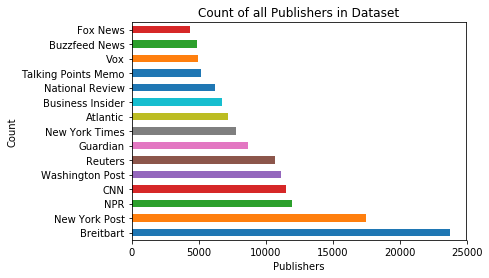

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

counts = df['publication'].value_counts() 
counts.plot.barh()
plt.title('Count of all Publishers in Dataset')
plt.xlabel('Publishers')
plt.ylabel('Count')

Visually there is a huge disparity between our max `Breitbart` and our min `Fox News` and it may affect our learning, it can be expected that our AI might not be able to properly identify posts from the publishers with less articles.

We might have to duplicate our minimum publishers with filler articles so that our classes can be uniformly distributed.

We'll now look at the word counts.

#### Average word counts throughout entire corpus

This has to be done because we must see if our articles are actually beefy enough and full of nutritious delicious information. The individual documents could actually just be bare bones for all we know.

I'll keep stopwords because I feel that some publishers may veer to certain strong pattern words. 

E.g. Propaganda in the olden days used `We` `Us` a lot, versus a modern legal document which may include no `We`s or `Us`s at all.

In [81]:
import re

sum_ = 0
for article in df['content'][:3000]:
    re.sub(r'\W', '', article)
    sum_ += len(article.split())
sum_/3000

744.7743333333333

Overall, is not a bad word count as an average.

In [82]:
pubs = list(counts.keys())
means = []
for pub in pubs:
    i = 0
    sum_ = 0
    counter_ = 0
    for i in range(4000):
        if df['publication'][i] == pub:
            article = df['content'][i]
            re.sub(r'\W', '', article)
            sum_ += len(article.split())
            counter_ += 1
    means.append(sum_/counter_)

Text(0,0.5,'Averages')

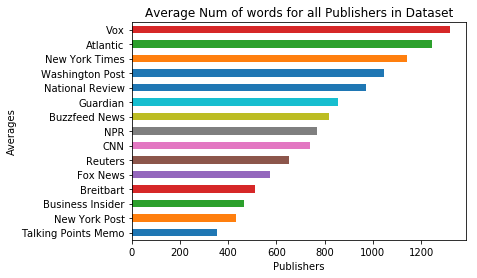

In [5]:
pub_avgs = pd.Series(means, index=pubs)
pub_avgs.sort_values().plot.barh()
plt.title('Average Num of words for all Publishers in Dataset')
plt.xlabel('Publishers')
plt.ylabel('Averages')

This makes a very interesting dynamic. As discussed earlier, since we might have to duplicate articles to make a uniformly distributed sample these averages say that some of the publishers with lower article counts have large word counts on average.

#### Largest TF-IDF scores

Doing this analysis can identify potentially similar publishers in terms of vocabulary and/or writing style. This could potentially be problematic as some groups of publishers would give the machine a harder time to determine differences.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_vect = tfidf.fit_transform(df['content'])
words = tfidf.get_feature_names()

In [47]:
# Unsurprisingly, computationally expensive, I need to read further scipy sparse_matrix documentation
def tfidf_per_class(X, y, margin, num_docs, tfidf_vect, words, unique_classes):
    if tfidf_vect.shape[1] != len(words):
        ValueError('Ensure that the number of unique words are the same as the number of words in the tfidf matrix')
        
    classes_dict = {class_:[] for class_ in unique_classes}
    
    y_ = y[:num_docs]
    # FOR: Documents
    for i in range(num_docs): 
        current_class = y_[i]
        current_doc = X[i].split()
        if i % 1 == 0: 
            print("%d iterations have passed" %(i))
            print("CURRENT CLASS at %d:\t%s"%(i, current_class))
            print("="*10)
        
        # FOR: Words in document
        for word in current_doc:
            if word not in words:
                continue
                
            j = words.index(word.lower())
            if tfidf_vect[i, j] >= margin and words[j] not in classes_dict[current_class]:
                classes_dict[current_class].append((words[j], tfidf_vect[i, j]))
    
    return classes_dict

In [67]:
_ = tfidf_per_class(0.2, 450, tfidf_vect, words, df['publication'], pubs)
_

{'Atlantic': [('cheerleaders', 0.32620490927491863),
  ('kountze', 0.4540952913241913),
  ('the', 0.39741378150911705),
  ('drake', 0.36874845499057435),
  ('song', 0.21452884665566282),
  ('the', 0.2528315023593392),
  ('convention', 0.2032919024262453),
  ('the', 0.31506963759293677),
  ('chartier', 0.26188222370568565),
  ('mosque', 0.45250965589975145),
  ('mosques', 0.21442470441246714),
  ('sanctuary', 0.3963631265623454),
  ('the', 0.24393262396742635),
  ('argentina', 0.22536406280927462),
  ('macri', 0.21582861894857133),
  ('the', 0.2940203795693286),
  ('bangladesh', 0.3735351609583379),
  ('jmb', 0.22560894321342043),
  ('riaz', 0.3609743091414727),
  ('the', 0.3507907089580018),
  ('korea', 0.5137570325744628),
  ('missile', 0.2253206903003575),
  ('north', 0.3537313982400288),
  ('the', 0.30019190225930675),
  ('ivanka', 0.25780964829606395),
  ('the', 0.3526547137186918),
  ('trump', 0.3498942693483353),
  ('evening', 0.29586873089889115),
  ('news', 0.24665044840523817)

In [68]:
tfidf_common = {key:[] for key in _}
for pub in _:
    for word, weight in _[pub]:
        if weight >= 0.4:
            tfidf_common[pub].append((word, weight))

In [79]:
tfidf_common

{'Atlantic': [('kountze', 0.4540952913241913),
  ('mosque', 0.45250965589975145),
  ('korea', 0.5137570325744628),
  ('the', 0.40985220847693193),
  ('song', 0.40474520170143646),
  ('rubio', 0.44028834893118957),
  ('tillerson', 0.511616890610267),
  ('barrows', 0.4986542238275879),
  ('goodridge', 0.4995994399632181),
  ('colleges', 0.45550170308678023)],
 'Breitbart': [('the', 0.4024382345224211),
  ('badawi', 0.5704323474557422),
  ('concert', 0.5818725205633805),
  ('luchese', 0.5036396230277254),
  ('daca', 0.6450860981012434),
  ('dapa', 0.4091426267986399),
  ('barron', 0.640279569617679),
  ('krikorian', 0.48482806682455776),
  ('falwell', 0.6582549974693609),
  ('cartel', 0.5012744761599709),
  ('nsa', 0.53717630033828),
  ('lsp', 0.42120443456337114),
  ('sabratha', 0.4544634904603115),
  ('thiel', 0.608020501272615),
  ('mcgowan', 0.45186356148338974),
  ('whitewashing', 0.40456905234005847),
  ('rory', 0.5291616355263423),
  ('merry', 0.4378786012075772),
  ('biden', 0.443

It seems like overall, the TFIDF should be able to tell publishers a part. We can see a very good picture about what each publisher likes to talk about.

For example, CNN:

In [81]:
tfidf_common['CNN']

[('gabbard', 0.6259766281117547),
 ('weather', 0.4089034640579169),
 ('arizona', 0.4175839193575786),
 ('georgia', 0.43053569086910526),
 ('kim', 0.5972229861215101),
 ('lockheed', 0.45483583501401004),
 ('sharry', 0.6566022030590477),
 ('roof', 0.4742775863878776),
 ('comey', 0.590808906097222),
 ('conley', 0.5789450645265706),
 ('roof', 0.5974925056619637),
 ('biden', 0.6455833006477149),
 ('cosby', 0.707211478973705),
 ('mosul', 0.5626109523144757),
 ('bland', 0.6157707274231398),
 ('water', 0.4630813914627429),
 ('camps', 0.463046003373227),
 ('alzheimer', 0.6006243390500712),
 ('matobato', 0.4368799234581847)]

Generally talks a lot about domestic US issues, with several US senators and states having high tfidf scores being a good indicator for their topics of interest.

Whereas, Vox:

In [82]:
tfidf_common['Vox']

[('holocaust', 0.6054792850255717),
 ('jones', 0.6395032996250319),
 ('the', 0.4137887022241183),
 ('the', 0.41012758259562576),
 ('leftovers', 0.4614590056564695),
 ('the', 0.4007022886504129),
 ('lovecraft', 0.5819855102616348),
 ('medicaid', 0.5016623684653213),
 ('calories', 0.6302861971122768),
 ('solange', 0.45215725673815527)]

Has more varied and niche terms dotting their articles, with `lovecraft` and `calories` being good indicators for their articles.

However, due to time constraints, it should be noted that these picks are from a very small sample size of 450 in terms of tfidf matrices. In fact it would severely limit the experessiveness of some of the publishers. Ideally, we should be using the entire dataset.

<a id='baseline'></a>
## Baseline

We'll use Keras with a [20,n_classes] architecture of Relu, Softmax at 50 epochs to test the waters first.

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.utils import to_categorical

# TF IDF
tfidf = TfidfVectorizer(tokenizer=nltk.word_tokenize,
                        token_pattern=r'\w+',
                        stop_words='english')
tfidf_mat = tfidf.fit_transform(X['train'])

# TF IDF Transform
transformer = TfidfTransformer()
X_trans = transformer.fit_transform(tfidf_mat)

# One hot encoding
le = LabelEncoder()
le.fit(y['train'])
encoded_y = to_categorical(le.transform(y['train']))

# Model Initilisation
model = Sequential([
    Dense(20, input_dim=tfidf_mat.shape[1], activation='relu'),
    Dense(15, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['categorical_crossentropy'])

In [22]:
model.fit(X_trans, encoded_y, epochs=1, batch_size=10)

Epoch 1/1
99799/99799 [==============================] - 1422s 14ms/step - loss: 0.4793 - categorical_crossentropy: 0.4793


#### Train set

In [53]:
from sklearn.metrics import f1_score

train_tfidf = tfidf.transform(X['train'][:3000])
print('Fit Transform...')
train_trans = transformer.fit_transform(train_tfidf)

print('Predicting...')
pred = model.predict(train_trans)

y_pred_train = []
for i in range(3000):
    y_pred_train.append(list(pred[i]).index(max(pred[i])))

Fit Transform...
Predicting...


In [54]:
y_actual_train = le.transform(y['train'][:3000])
f1_score(y_actual_train, y_pred_train, average='weighted')

0.9870086968057195

#### Dev set

In [59]:
# TF IDF Transform
dev_tfidf = tfidf.transform(X['dev'][:3000])
print('Fit Transform...')
dev_trans = transformer.fit_transform(dev_tfidf)

print('Predicting...')
pred = model.predict(dev_trans)

y_pred_dev = []
for i in range(3000):
    y_pred_dev.append(list(pred[i]).index(max(pred[i])))

Fit Transform...
Predicting...


In [60]:
y_actual_dev = le.transform(y['dev'][:3000])
f1_score(y_actual_dev, y_pred_dev, average='weighted')

0.8225385916843302

<a id='discussion'></a>
## Discussion

I feel like there was something critically wrong with how I've approached the baseline, as it took almost an hour to instantiate and train. However it is a slightly more complex model so it might be of expect.

Surprisingly we have a very good accuracy rating, but there is evidence of overfitting with a difference of more than 15% from training to the dev set.

We should investigate the classes that are particularly troublesome, via a confusion matrix.

In [73]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

cf_train = confusion_matrix(y_actual_train, y_pred_train)
cf_dev = confusion_matrix(y_actual_dev, y_pred_dev)

In [76]:
# Sourced from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


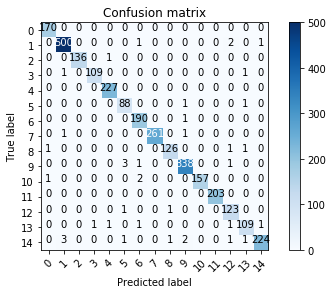

In [86]:
plot_confusion_matrix(cf_train, classes=range(15))

Confusion matrix, without normalization


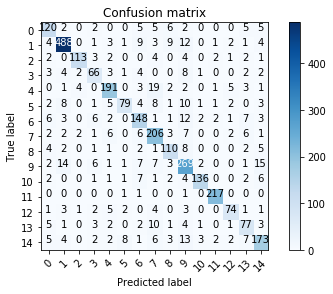

In [87]:
plot_confusion_matrix(cf_dev, classes=range(15))

As expected with the training set, the confusion matrix is almost perfect due to it's overfitting.

Looking at the dev set, we can conclude that there are clearly some labels that are related. Of from the chart, (predicted=4, true=7):

In [84]:
pubs[4], pubs[7]

('Washington Post', 'New York Times')

`New York Times` in particular is getting confused a lot with other news sources.

In [89]:
tfidf_common['New York Times']

NameError: name 'tfidf_common' is not defined

In [90]:
tfidf_common['Washington Post']

NameError: name 'tfidf_common' is not defined